# Sheet 3

| Network            |  Test Error  | 
|:-------------------|:------------:|
| LIN                |   0.0169     |
| LIN + DO           |   0.2363     |
| LIN + DO + PR      |   0.0153      |
| CONV               |   0.0186     |
| CONV unisotropic   |   0.0123     | 


## 3.1 Introduction

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [24]:
plt.rc("figure", dpi=100)

In [25]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [26]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 3.90e-01
Mean Test Loss:  2.81e-01
Epoch: 10
Mean Train Loss: 1.55e-01
Mean Test Loss:  3.31e-01
Epoch: 20
Mean Train Loss: 1.14e-01
Mean Test Loss:  5.15e-01
Epoch: 30
Mean Train Loss: 8.16e-02
Mean Test Loss:  5.41e-01
Epoch: 40
Mean Train Loss: 5.10e-02
Mean Test Loss:  5.49e-01
Epoch: 50
Mean Train Loss: 3.87e-02
Mean Test Loss:  6.52e-01
Epoch: 60
Mean Train Loss: 3.52e-02
Mean Test Loss:  7.21e-01
Epoch: 70
Mean Train Loss: 2.24e-02
Mean Test Loss:  8.16e-01
Epoch: 80
Mean Train Loss: 1.10e-02
Mean Test Loss:  8.20e-01
Epoch: 90
Mean Train Loss: 8.04e-03
Mean Test Loss:  9.01e-01
Epoch: 100
Mean Train Loss: 8.67e-03
Mean Test Loss:  8.24e-01


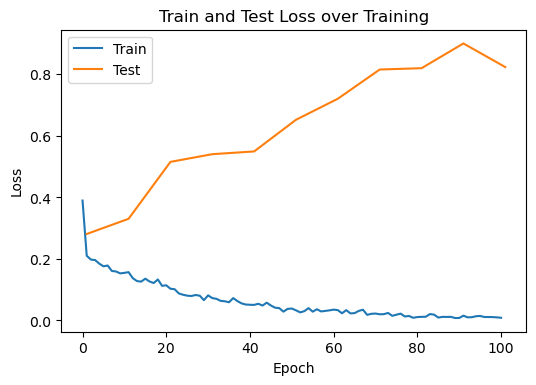

In [27]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [30]:
with torch.no_grad():
    error=0
    for i, (x,y) in enumerate(test_dataset):
        if torch.argmax(model(x.flatten(), w_h, w_h2, w_o)).item()!=y:
            error+=1
print(f"Test-error: {error/len(test_dataset)}")

Test-error: 0.0169


## 3.2 Dropout

In [31]:
def dropout(X, p_drop=0.5):
    if 0<p_drop<1:
        return torch.where(torch.rand_like(X) < p_drop, 0, X/(1-p_drop))
    return X

def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x_drop = dropout(x,p_drop=p_drop_input) 
    h = rectify(x_drop @ w_h)
    h_drop = dropout(h,p_drop=p_drop_hidden) 
    h2 = rectify(h_drop @ w_h2)
    h2_drop = dropout(h2,p_drop=p_drop_hidden) 
    pre_softmax = h2_drop @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 1.02e+00
Mean Test Loss:  3.22e-01
Epoch: 10
Mean Train Loss: 1.02e+00
Mean Test Loss:  3.25e-01
Epoch: 20
Mean Train Loss: 1.32e+00
Mean Test Loss:  4.00e-01
Epoch: 30
Mean Train Loss: 1.50e+00
Mean Test Loss:  4.48e-01
Epoch: 40
Mean Train Loss: 1.64e+00
Mean Test Loss:  5.75e-01
Epoch: 50
Mean Train Loss: 1.77e+00
Mean Test Loss:  5.91e-01
Epoch: 60
Mean Train Loss: 1.82e+00
Mean Test Loss:  6.26e-01
Epoch: 70
Mean Train Loss: 1.96e+00
Mean Test Loss:  6.30e-01
Epoch: 80
Mean Train Loss: 2.09e+00
Mean Test Loss:  6.25e-01
Epoch: 90
Mean Train Loss: 2.08e+00
Mean Test Loss:  7.41e-01
Epoch: 100
Mean Train Loss: 2.23e+00
Mean Test Loss:  6.92e-01


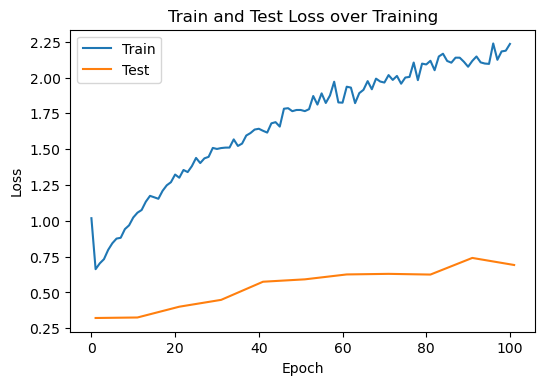

In [32]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

p_drop_input = 0.5

p_drop_hidden = 0.5

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [33]:
with torch.no_grad():
    error=0
    for i, (x,y) in enumerate(test_dataset):
        if torch.argmax(dropout_model(x.flatten(), w_h, w_h2, w_o, 0, 0)).item()!=y:
            error+=1
    print(f"Test-error: {error/len(test_dataset)}")

Test-error: 0.2363


The dropout method sets some neurons to zero. Neurons from the next layer, which are connected with a weight to this neuron, then get no information. In order to still accuralely predict the outcome, a neuron therefore cannot depend on sigualar neurons from the previous layer and has to find a more general model. This reduces overfitting and is one method of regularization.

The plot shows that the Test-loss stays constant (slightly increasing but less than in task 1). However the Train-loss increases after 2 epochs. This occurs when there is too much dropout

## 3.3 Parametric Relu

In [34]:
def PRelu(X,a):
    return torch.where(X>0,X,a*X)

def PRelu_model(x, w_h, w_h2, w_o, a1, a2, p_drop_input , p_drop_hidden):
    xd = dropout(x, p_drop_input)
    h = PRelu(xd @ w_h , a1)
    hd = dropout(h, p_drop_hidden)
    h2 = PRelu(hd @ w_h2, a2)
    h2d = dropout(h2, p_drop_hidden)
    pre_softmax = h2d @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 5.32e-01
Mean Test Loss:  2.16e-01
Epoch: 10
Mean Train Loss: 2.06e-01
Mean Test Loss:  1.28e-01
Epoch: 20
Mean Train Loss: 1.86e-01
Mean Test Loss:  1.18e-01
Epoch: 30
Mean Train Loss: 1.75e-01
Mean Test Loss:  1.38e-01
Epoch: 40
Mean Train Loss: 1.62e-01
Mean Test Loss:  1.22e-01
Epoch: 50
Mean Train Loss: 1.62e-01
Mean Test Loss:  1.66e-01
Epoch: 60
Mean Train Loss: 1.57e-01
Mean Test Loss:  1.33e-01
Epoch: 70
Mean Train Loss: 1.52e-01
Mean Test Loss:  1.27e-01
Epoch: 80
Mean Train Loss: 1.47e-01
Mean Test Loss:  1.77e-01
Epoch: 90
Mean Train Loss: 1.48e-01
Mean Test Loss:  1.33e-01
Epoch: 100
Mean Train Loss: 1.34e-01
Mean Test Loss:  1.21e-01


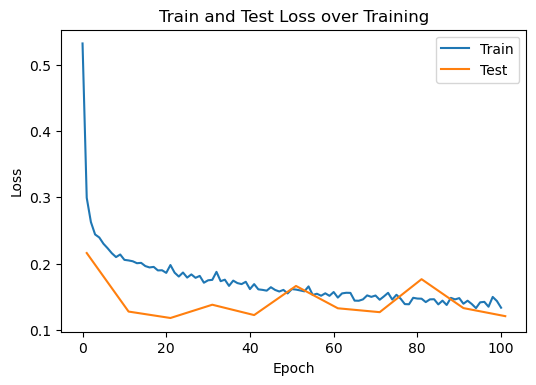

In [35]:
w_h = init_weights((784, 625))
a1 = init_weights((625,))
w_h2 = init_weights((625, 625))
a2 = init_weights((625,))
w_o = init_weights((625, 10))

optimizer = RMSprop(params=[w_h, w_h2, w_o, a1, a2])


p_drop_input = 0.2
p_drop_hidden = 0.2
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = PRelu_model(x, w_h, w_h2, w_o, a1, a2, p_drop_input , p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = PRelu_model(x, w_h, w_h2, w_o, a1, a2, 0 , 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [36]:
with torch.no_grad():
    error=0
    for i, (x,y) in enumerate(test_dataset):
        if torch.argmax(PRelu_model(x.flatten(), w_h, w_h2, w_o, a1, a2, 0 , 0)).item()!=y:
            error+=1
    print(f"Test-error: {error/len(test_dataset)}")

Test-error: 0.0153


Since there was too much dropout in 2 we drecreased it to 0.2.

Now both Train- and Test-loss are at 0.1 after training finished

## 3.4 Convolutional layers

![](network_layers.PNG)

We now look at Convolutional Neural Networks (CNN). In accordance with the Problem Set 03 we sketched the network:

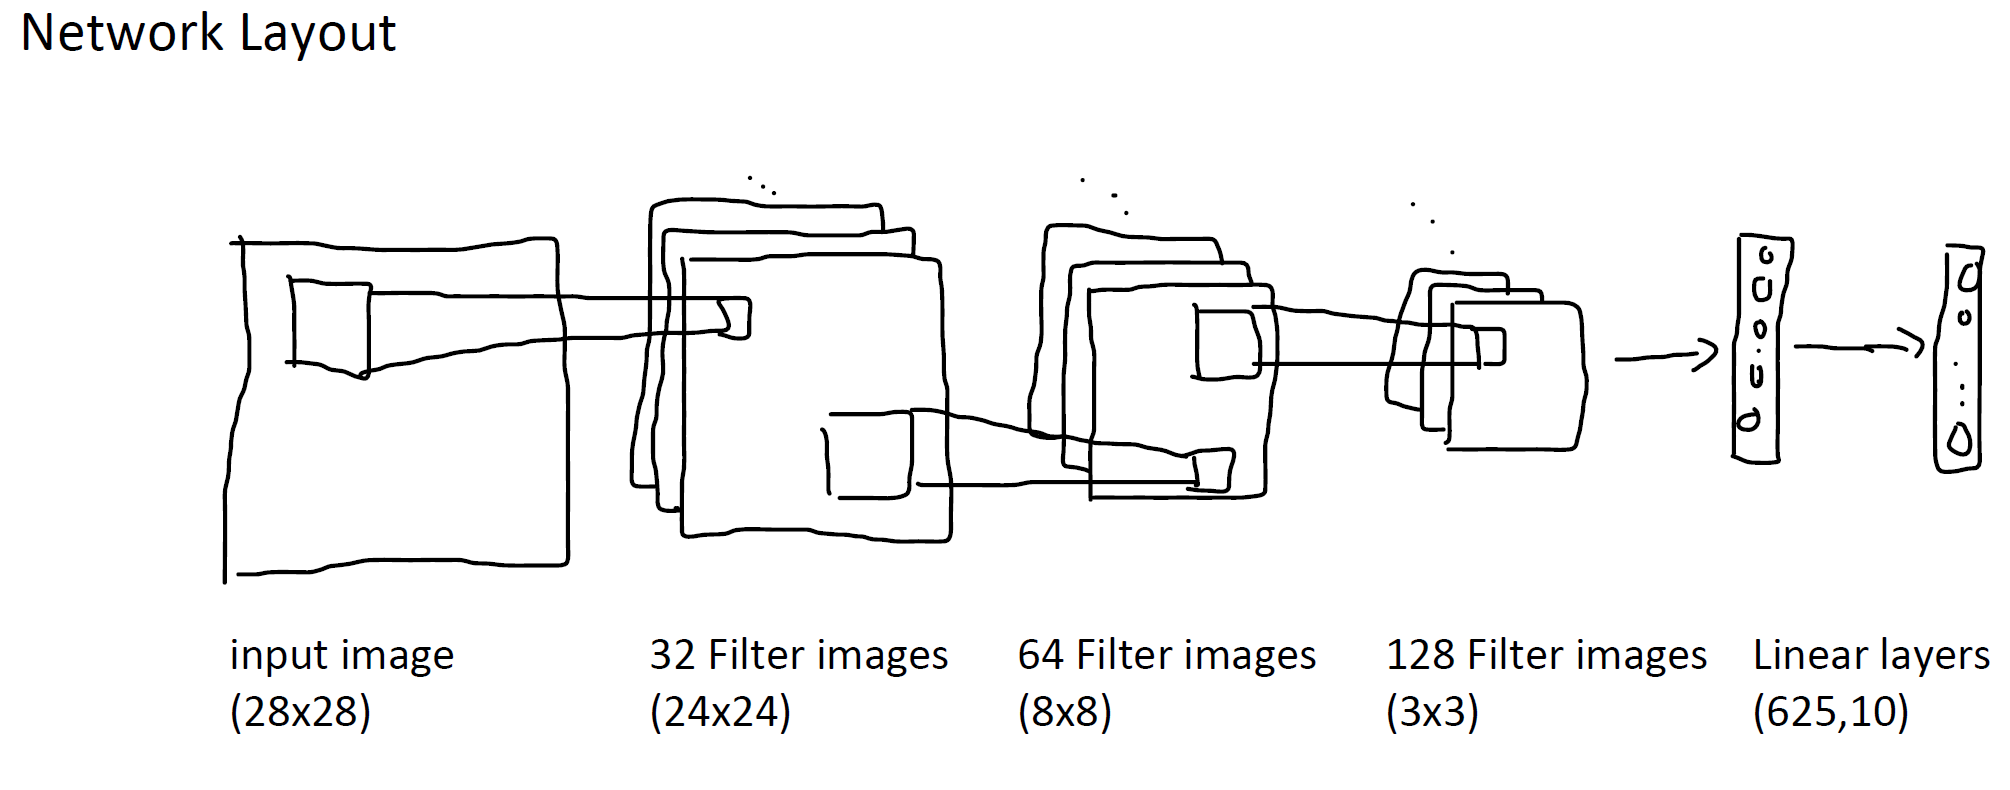

In [14]:
def conv_model(x, filter1, filter2, filter3, w_h2, w_o, a2 , p_drop_input, p_drop_hidden):
    xd = dropout(x, p_drop_input).reshape(-1, 1, 28, 28)
    conv1 = rectify(conv2d(xd, filter1))
    ss1 = max_pool2d(conv1, (2, 2))
    d1 = dropout(ss1, p_drop_input)
    conv2 = rectify(conv2d(d1, filter2))
    ss2 = max_pool2d(conv2, (2, 2))
    d2 = dropout(ss2, p_drop_input)
    conv3 = rectify(conv2d(d2, filter3))
    ss3 = max_pool2d(conv3, (2, 2))
    d3 = dropout(ss3, p_drop_input)
    conv_out = d3.reshape(-1,128)
    h2 = PRelu(conv_out @ w_h2, a2)
    h2d = dropout(h2, p_drop_hidden)
    pre_softmax = h2d @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 2.00e+00
Mean Test Loss:  2.36e-01
Epoch: 10
Mean Train Loss: 2.76e-01
Mean Test Loss:  1.00e-01
Epoch: 20
Mean Train Loss: 2.72e-01
Mean Test Loss:  9.17e-02
Epoch: 30
Mean Train Loss: 2.68e-01
Mean Test Loss:  1.15e-01
Epoch: 40
Mean Train Loss: 2.67e-01
Mean Test Loss:  8.02e-02
Epoch: 50
Mean Train Loss: 2.85e-01
Mean Test Loss:  7.55e-02
Epoch: 60
Mean Train Loss: 2.89e-01
Mean Test Loss:  9.36e-02
Epoch: 70
Mean Train Loss: 3.04e-01
Mean Test Loss:  8.50e-02
Epoch: 80
Mean Train Loss: 3.08e-01
Mean Test Loss:  1.05e-01
Epoch: 90
Mean Train Loss: 3.06e-01
Mean Test Loss:  9.38e-02
Epoch: 100
Mean Train Loss: 3.18e-01
Mean Test Loss:  9.28e-02


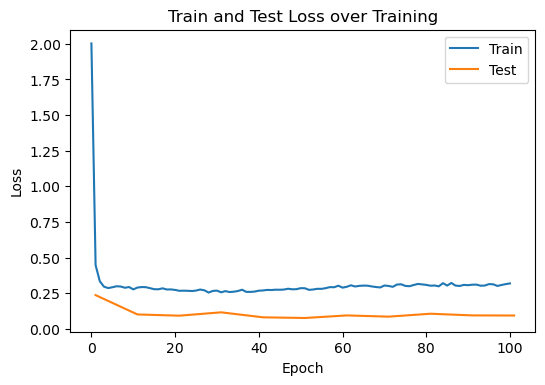

In [16]:
# initialize weights

filter1 = init_weights((32, 1 , 5 , 5))
filter2 = init_weights((64, 32 , 5 , 5))
filter3 = init_weights((128, 64 , 2 , 2))

w_h2 = init_weights((128, 625))
a2 = init_weights((625,))
w_o = init_weights((625, 10))

optimizer = RMSprop(params=[filter1, filter2, filter3, w_h2, w_o, a2])

p_drop_input = 0.2
p_drop_hidden = 0.2
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = conv_model(x, filter1, filter2, filter3, w_h2, w_o, a2 , p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = conv_model(x, filter1, filter2, filter3, w_h2, w_o, a2 , 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [17]:
with torch.no_grad():
    error=0
    for i, (x,y) in enumerate(test_dataset):
        if torch.argmax(conv_model(x.flatten(), filter1, filter2, filter3, w_h2, w_o, a2 , 0, 0)).item()!=y:
            error+=1
print(f"Test-error: {error/len(test_dataset)}")

Test-error: 0.0186


torch.Size([1, 32, 24, 24])


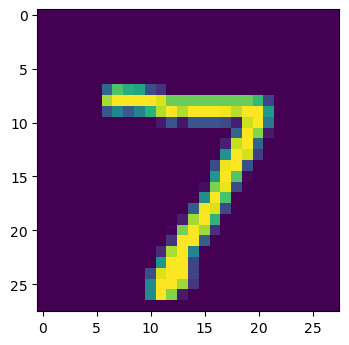

<Figure size 600x400 with 0 Axes>

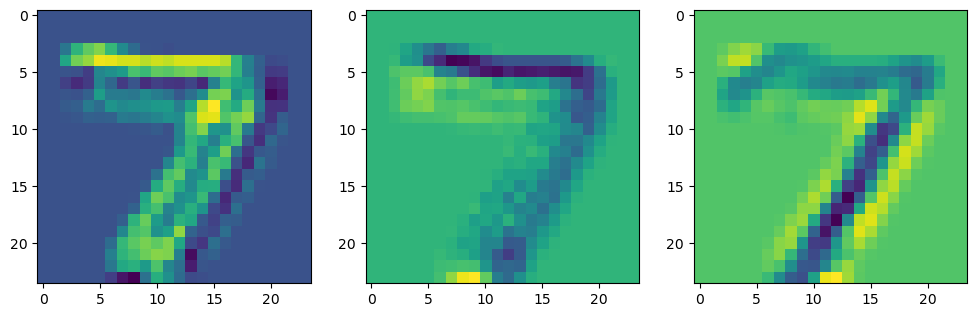

<Figure size 600x400 with 0 Axes>

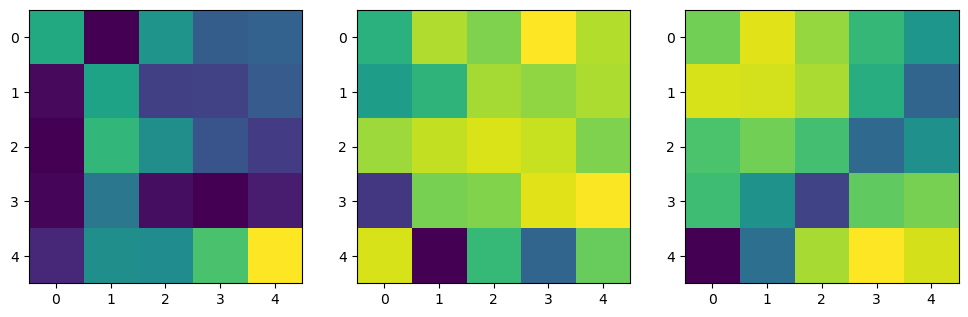

In [20]:
image = (next(iter(test_dataloader))[0].reshape(-1, 1, 28, 28)[0])[None,...]

plt.figure()
plt.imshow(image[0,0,:,:])

conv1 = conv2d(image, filter1)
ss1 = max_pool2d(conv1, (2, 2))
print(conv1.shape)

plt.figure()
fig, ax1 = plt.subplots(1,3,figsize=(12,5))
ax1[0].imshow(conv1[0,1,:,:].detach().numpy())
ax1[1].imshow(conv1[0,2,:,:].detach().numpy())
ax1[2].imshow(conv1[0,3,:,:].detach().numpy())

plt.figure()
fig, ax1 = plt.subplots(1,3,figsize=(12,5))
f1d = filter1.detach().numpy()
ax1[0].imshow(f1d[1,0,:,:])
ax1[1].imshow(f1d[2,0,:,:])
ax1[2].imshow(f1d[3,0,:,:])

## Use unisotropic Filters $k_x \neq k_y$

Epoch: 0
Mean Train Loss: 1.95e+00
Mean Test Loss:  1.95e-01
Epoch: 10
Mean Train Loss: 2.43e-01
Mean Test Loss:  8.17e-02
Epoch: 20
Mean Train Loss: 2.35e-01
Mean Test Loss:  7.17e-02


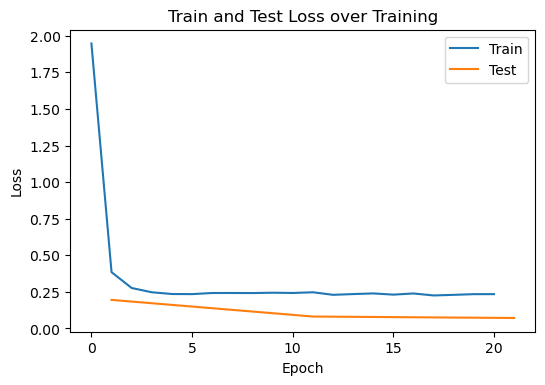

In [21]:
#use unisotropic filters
def conv_model_2(x, filter1, filter2, filter3, w_h2, w_o, a2 , p_drop_input, p_drop_hidden):
    xd = dropout(x, p_drop_input).reshape(-1, 1, 28, 28)
    conv1 = rectify(conv2d(xd, filter1))
    ss1 = max_pool2d(conv1, (2, 2))
    d1 = dropout(ss1, p_drop_input)
    conv2 = rectify(conv2d(d1, filter2))
    ss2 = max_pool2d(conv2, (2, 2))
    d2 = dropout(ss2, p_drop_input)
    conv3 = rectify(conv2d(d2, filter3))
    ss3 = max_pool2d(conv3, (2, 2))
    d3 = dropout(ss3, p_drop_input)
    conv_out = d3.reshape(-1,128)
    h2 = PRelu(conv_out @ w_h2, a2)
    h2d = dropout(h2, p_drop_hidden)
    pre_softmax = h2d @ w_o
    return pre_softmax

filter1 = init_weights((32, 1 , 7 , 3))
filter2 = init_weights((64, 32 , 4 , 6))
filter3 = init_weights((128, 64 , 3 , 3))
# x: 28 -> 22;11 -> 8;4 -> 2;1
# y: 28 -> 26;13 -> 8;4 -> 2;1

w_h2 = init_weights((128, 625))
a2 = init_weights((625,))
w_o = init_weights((625, 10))

optimizer = RMSprop(params=[filter1, filter2, filter3, w_h2, w_o, a2])

p_drop_input = 0.2
p_drop_hidden = 0.2
n_epochs = 20

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = conv_model_2(x, filter1, filter2, filter3, w_h2, w_o, a2 , p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = conv_model_2(x, filter1, filter2, filter3, w_h2, w_o, a2 , 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [22]:
with torch.no_grad():
    error=0
    for i, (x,y) in enumerate(test_dataset):
        if torch.argmax(conv_model_2(x.flatten(), filter1, filter2, filter3, w_h2, w_o, a2 , 0, 0)).item()!=y:
            error+=1
    print(f"Test-error: {error/len(test_dataset)}")

Test-error: 0.0123


The test error is approx 40% lower than conv_model